In [21]:
import os
import pathlib
import numpy as np
import cv2
from tensorflow import keras
import tensorflow as tf
from keras import layers, preprocessing, callbacks, losses, utils, models, regularizers
from keras.utils import plot_model
import sys
import PyQt5
from PyQt5.QtWidgets import QApplication, QLabel, QWidget, QVBoxLayout, QHBoxLayout, QGridLayout,QFrame
from PyQt5.QtGui import QPixmap, QPainter, QPen, QColor
from PyQt5.QtCore import Qt
import time
import glob
from collections import defaultdict
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, log_loss, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Détection GPU
devices = tf.config.list_physical_devices()
gpu_devices = [d for d in devices if d.device_type == "GPU"]
if gpu_devices:
    print("GPU détecté :", gpu_devices)
else:
    print("Aucun GPU Apple détecté, utilisation du CPU.")

GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# =========================
# 1) Parsing des fichiers
# =========================

def load_sequence_txt(path):
    feats = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Détection automatique du séparateur
            if ";" in line:
                parts = [p for p in line.split(";") if p.strip() != ""]
            else:
                parts = [p for p in line.split() if p.strip() != ""]
            try:
                vec = list(map(float, parts))
            except ValueError:
                print(f"Ligne ignorée dans {path}: {line[:50]}...")
                continue
            feats.append(vec)
    X = np.array(feats, dtype=np.float32)
    return X

In [5]:
# =========================
# 2) Prétraitements
# =========================

def normalize_framewise(X):
    Xn = X.copy()
    mu = Xn.mean(axis=0, keepdims=True)      # (1, D)
    sigma = Xn.std(axis=0, keepdims=True) + 1e-8
    Xn = (Xn - mu) / sigma
    return Xn

def load_dataset_from_folder(seq_folder):
    sequences = sorted(glob.glob(os.path.join(seq_folder, "*.txt")))
    X_list, y_list = [], []
    label_to_id = {}
    next_id = 0

    for path in sequences:
        label = os.path.splitext(os.path.basename(path))[0]
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = [p for p in line.split() if p.strip() != ""]
                try:
                    vec = list(map(float, parts))
                except ValueError:
                    continue
                X_list.append(vec)
                if label not in label_to_id:
                    label_to_id[label] = next_id
                    next_id += 1
                y_list.append(label_to_id[label])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)

    id_to_label = {v: k for k, v in label_to_id.items()}
    class_names = [id_to_label[i] for i in range(len(id_to_label))]

    print(f"Dataset chargé : {len(X)} exemples, {X.shape[1]} coordonnées, classes = {class_names}")
    return X, y, class_names

In [6]:
# =========================
# 4) Modèle (BatchNorm + Dropout + L2)
# =========================

def make_model(D, C):
    reg = regularizers.l2(1e-4)
    model = keras.Sequential([
        layers.Input(shape=(D,)),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_regularizer=reg),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=reg),
        layers.Dropout(0.3),
        layers.Dense(C, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# ================
# 5) Entraînement
# ================

# Dossier où se trouvent les fichiers *.txt
seq_folder = "/Users/valentindaveau/Documents/UE_Vision/Coords" 

# Construire le dataset
X, y, class_names = load_dataset_from_folder(seq_folder)
print("Dataset:", X.shape, y.shape, class_names)

train_val=0.8

# Split simple (train/val)
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(train_val * len(X))
tr, va = idx[:split], idx[split:]
Xtr, ytr = X[tr], y[tr]
Xva, yva = X[va], y[va]
np.save("X_val.npy", Xva)
np.save("y_val.npy", yva)
print("Jeux de validation sauvegardés : X_val.npy et y_val.npy")

# Normalisation globale basée sur le train
mu = Xtr.mean(axis=0, keepdims=True)
sigma = Xtr.std(axis=0, keepdims=True) + 1e-8
Xtr = (Xtr - mu) / sigma
Xva = (Xva - mu) / sigma
np.save("norm_mu.npy", mu)
np.save("norm_sigma.npy", sigma)
print("Normalisation globale appliquée (moyenne et écart-type sauvegardés).")

D = X.shape[1]
C = len(class_names)

model_path = "modele_gestes_20x64_80%_16g.keras"

if os.path.exists(model_path):
    print("Modèle trouvé, chargement du modèle sauvegardé...")
    model = keras.models.load_model(model_path)
    class_names = np.load("class_names.npy", allow_pickle=True).tolist()
    print("Noms de classes chargés :", class_names)
else:
    print("Aucun modèle trouvé, entraînement en cours...")
    model = make_model(D,C)
    start_time = time.time()
    history = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=20, batch_size=64)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Temps d'entraînement : {training_time:.2f} secondes ({training_time/60:.2f} min)")
    model.save(model_path)
    print(f"Modèle sauvegardé sous : {model_path}")
    np.save("class_names.npy", class_names)
    print("Noms de classes sauvegardés dans class_names.npy")



def normalize_landmarks(X20: np.ndarray) -> np.ndarray:
    wrist = X20[0]
    Xc = X20 - wrist
    # distance de ref: WRIST (0) -> MIDDLE MCP (index MediaPipe 9, devenu X20[8] après mapping)
    scale = np.linalg.norm(Xc[8]) + 1e-8
    return Xc / scale

Dataset chargé : 452428 exemples, 63 coordonnées, classes = ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three3', 'thumb_index2']
Dataset: (452428, 63) (452428,) ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three3', 'thumb_index2']
Jeux de validation sauvegardés : X_val.npy et y_val.npy
Normalisation globale appliquée (moyenne et écart-type sauvegardés).
Aucun modèle trouvé, entraînement en cours...
Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/20


2025-11-15 15:52:33.457096: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5656/5656 [==============================] - 113s 20ms/step - loss: 0.4798 - accuracy: 0.8631 - val_loss: 0.3339 - val_accuracy: 0.9064
Epoch 2/20
5656/5656 [==============================] - 102s 18ms/step - loss: 0.3756 - accuracy: 0.8940 - val_loss: 0.3257 - val_accuracy: 0.9092
Epoch 3/20
5656/5656 [==============================] - 124s 22ms/step - loss: 0.3612 - accuracy: 0.8979 - val_loss: 0.3171 - val_accuracy: 0.9109
Epoch 4/20
5656/5656 [==============================] - 101s 18ms/step - loss: 0.3526 - accuracy: 0.8999 - val_loss: 0.3146 - val_accuracy: 0.9114
Epoch 5/20
5656/5656 [==============================] - 129s 23ms/step - loss: 0.3457 - accuracy: 0.9017 - val_loss: 0.3117 - val_accuracy: 0.9120
Epoch 6/20
5656/5656 [==============================] - 122s 22ms/step - loss: 0.3418 - accuracy: 0.9024 - val_loss: 0.3107 - val_accuracy: 0.9111
Epoch 7/20
5656/5656 [==============================] - 92s 16ms/step - loss: 0.3383 - accuracy: 0.9036 - val_loss: 0.3084 - val_

In [9]:
# =========================
# 6) Chargement et informations du modèle
# =========================

model = keras.models.load_model("modele_gestes_20x64_80%_16g.keras")

X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")

plot_model(model, to_file='modele.png', show_shapes=True, show_layer_names=True, dpi=96)
print(model.optimizer.get_config())
print(model.loss)
print(model.metrics)

class_names = np.load("class_names.npy", allow_pickle=True).tolist()
mu = np.load("norm_mu.npy")
sigma = np.load("norm_sigma.npy")

X_val = (X_val - mu) / sigma

class_names = np.load("class_names.npy", allow_pickle=True).tolist()
print("Classes connues par le modèle :", class_names)
print("Nombre total de classes :", len(class_names))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
<function sparse_categorical_crossentropy at 0x17e8c1750>
[<keras.metrics.base_metric.Mean object at 0x3424518a0>, <keras.metrics.base_metric.MeanMetricWrapper object at 0x3424509d0>]
Classes connues par le modèle : ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three3', 'thumb_index2']
Nombre total de classes : 16


2828/2828 [==============================] - 6s 2ms/step


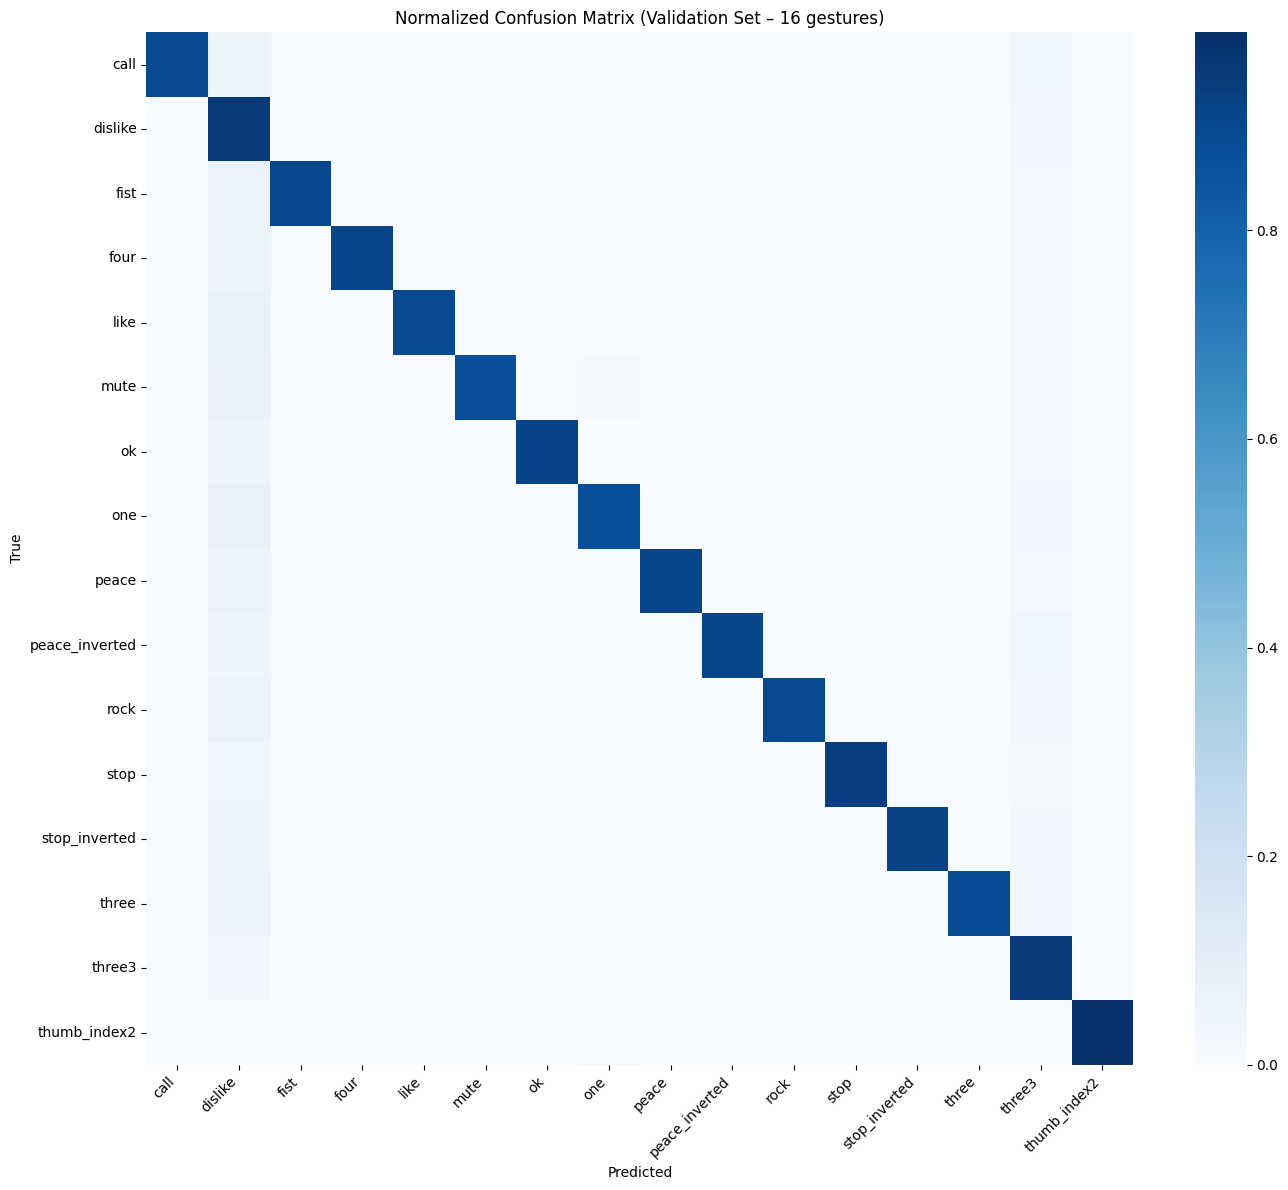

                precision  recall  f1-score    support
call                0.980   0.891     0.934   5267.000
dislike             0.532   0.952     0.683   5569.000
fist                0.988   0.903     0.944   5692.000
four                0.986   0.914     0.948   5803.000
like                0.967   0.890     0.927   5549.000
mute                0.985   0.877     0.928   5715.000
ok                  0.998   0.917     0.956   5751.000
one                 0.965   0.873     0.917   5659.000
peace               0.992   0.909     0.948   5806.000
peace_inverted      0.987   0.912     0.948   5501.000
rock                0.987   0.895     0.939   5769.000
stop                0.988   0.933     0.960   5867.000
stop_inverted       0.977   0.922     0.948   5352.000
three               0.993   0.885     0.936   5570.000
three3              0.780   0.953     0.858   7926.000
thumb_index2        0.993   0.990     0.991   3690.000
accuracy            0.913   0.913     0.913      0.913
macro avg 

In [24]:
# =========================
# 7) Détails du modèle (matrice de confusion, rapport de classification)
# =========================

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = y_val

cm = confusion_matrix(y_true_labels, y_pred_labels, normalize="true")

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Validation Set – 16 gestures)")
plt.tight_layout()
plt.savefig("confusion_matrix_16g.png", dpi=300, bbox_inches='tight')
plt.show()

report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)

df_report = pd.DataFrame(report).transpose()

df_report = df_report.round(3)

print(df_report)

with open("classification_report_16g.tex", "w") as f:
    f.write(df_report.to_latex(index=True, float_format="%.3f"))

print("Tableau LaTeX sauvegardé : classification_report_16g.tex")

mcc = matthews_corrcoef(y_true_labels, y_pred_labels)
kappa = cohen_kappa_score(y_true_labels, y_pred_labels)
ll = log_loss(y_true_labels, y_pred)
auc = roc_auc_score(y_true_labels, y_pred, multi_class="ovr")
print(f"MCC={mcc:.4f} | Kappa={kappa:.4f} | LogLoss={ll:.4f} | MacroAUC={auc:.4f}")

metrics_table = pd.DataFrame({
    "Metric": ["MCC", "Cohen's Kappa", "Log Loss", "Macro AUC"],
    "Value": [mcc, kappa, ll, auc]
})

metrics_table["Value"] = metrics_table["Value"].round(4)

print(metrics_table)

with open("global_metrics.tex", "w") as f:
    f.write(metrics_table.to_latex(index=False))

print("Tableau LaTeX enregistré dans global_metrics.tex")

In [ ]:
# =========================
# 8) Test à la caméra
# =========================

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Ouverture caméra
cap = None
for i in [0, 1]:
    cap = cv2.VideoCapture(i, cv2.CAP_AVFOUNDATION)
    if cap.isOpened():
        print(f"Caméra ouverte à l'index {i}")
        break
if cap is None or not cap.isOpened():
    raise RuntimeError("Aucune caméra utilisable détectée.")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 30)
time.sleep(1.0)

cv2.namedWindow("Reconnaissance de gestes", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Reconnaissance de gestes", 900, 700)

last_pred_time = 0
pred_interval = 0.3
last_preds = None
last_top3_idx = None

print("Caméra prête. Appuie sur ESC pour quitter.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("cap.read() a échoué.")
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    out = frame.copy()
    now = time.time()

    # --- Détection et prédiction ---
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(out, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark], dtype=np.float32).flatten()
            coords = (coords - mu.flatten()) / sigma.flatten()

            # Nouvelle prédiction une fois par seconde
            if now - last_pred_time > pred_interval:
                preds = model.predict(np.expand_dims(coords, axis=0), verbose=0)[0]
                top3_idx = preds.argsort()[-3:][::-1]
                last_preds = preds
                last_top3_idx = top3_idx
                last_pred_time = now

    # --- Affichage du dernier résultat connu (à chaque frame) ---
    if last_preds is not None and last_top3_idx is not None:
        for i, idx in enumerate(last_top3_idx):
            text = f"{class_names[idx]} : {last_preds[idx]*100:.1f}%"
            y_pos = 40 + i * 35
            color = (0, 255, 0) if i == 0 else (255, 255, 255)
            cv2.putText(out, text, (20, y_pos),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)

    # --- Affichage caméra ---
    cv2.imshow("Reconnaissance de gestes", out)
    if cv2.waitKey(5) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1763029239.840054 12105383 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763029239.864739 12105835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763029239.871529 12105840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Caméra ouverte à l'index 0
Caméra prête. Appuie sur ESC pour quitter.


W0000 00:00:1763029252.451351 12105836 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
2025-11-13 11:20:52.502643: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


: 